## Load trained model

In [1]:
import sys
sys.path.insert(0, '../src')
import numpy as np
import tensorflow as tf
from main import discriminator
from zap50k import zap_data, IMAGE_SIZE
import itertools
import scipy.misc
from glob import glob
import os
from random import randint

build_number = "2"
data_dir = os.environ.get('DATA_DIR')

In [2]:
files = glob(data_dir+'/*/*/*/*.jpg')

### Just small subset of training set

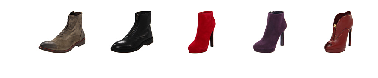

In [3]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from IPython.display import Image
fig = figure()
for i in range(5):
    a=fig.add_subplot(1,5,i+1)
    image = imread(files[i])
    imshow(image,cmap='Greys_r')
    axis('off')
fig

### Uploading features vector that was saved on the last training phase

In [4]:
#load all features
import pickle
with open(build_number+'/features.pkl', 'rb') as input:
    all_features = pickle.load(input)
    all_paths = pickle.load(input)

### Load pretrained model from latest checkpoint.
- Slect features from 10 random image.
- Find nearest features from all dataset


In [5]:
#Load model
with tf.Session() as sess:
    x = tf.placeholder(tf.float32, shape=[
        None, IMAGE_SIZE['resized'][0], IMAGE_SIZE['resized'][1], 3],name='x')
    dropout = tf.placeholder(tf.float32,name='dropout')
    feat_model = discriminator(x, reuse=False, dropout=dropout, int_feats=True)
    x1 = tf.placeholder(tf.float32, shape=[None, all_features.shape[1]])
    x2 = tf.placeholder(tf.float32, shape=[None, all_features.shape[1]])
    l2diff = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(x1, x2)), axis=1))

    # Init
    init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
    sess.run(init_op)

    saver = tf.train.Saver()
    checkpoint = build_number+'/checkpoint-4001'
    saver.restore(sess, checkpoint)
    #Make test functions
    def similarity(img_name,size):
        X = np.zeros([1,IMAGE_SIZE['resized'][0], IMAGE_SIZE['resized'][1], 3], dtype=np.float32)
        img = scipy.misc.imread(img_name, mode='RGB')
        img = scipy.misc.imresize(img, IMAGE_SIZE['resized'])
        img = img * (1. / 255) - 0.5
        X[0] = img
        test_feature = sess.run(feat_model, feed_dict={x: X,dropout: 1})
        def select_images(distances):
            indices = np.argsort(distances)
            images = []
            for i in range(size):
                images += [dict(path=all_paths[indices[i]],
                            index=indices[i],
                            distance=distances[indices[i]])]
            return images
        bs = 100
        item_block = np.reshape(np.tile(test_feature[0], bs), [bs, -1])
        distances = np.zeros(all_features.shape[0])
        for i in range(0, all_features.shape[0], bs):
            if i + bs > all_features.shape[0]:
                bs = all_features.shape[0] - i
            distances[i:i + bs] = sess.run(l2diff, feed_dict={x1: item_block[:bs], x2: all_features[i:i + bs]})
        return select_images(distances)
    needles = [randint(0, len(files)) for v in range(10)]
    result_out = []
    result_in = []
    for needle in needles:
        res = similarity(files[needle],10)
        result_out += [res]
        result_in += [files[needle]]

INFO:tensorflow:Restoring parameters from 2/checkpoint-4001


# Here we are!!!

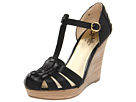

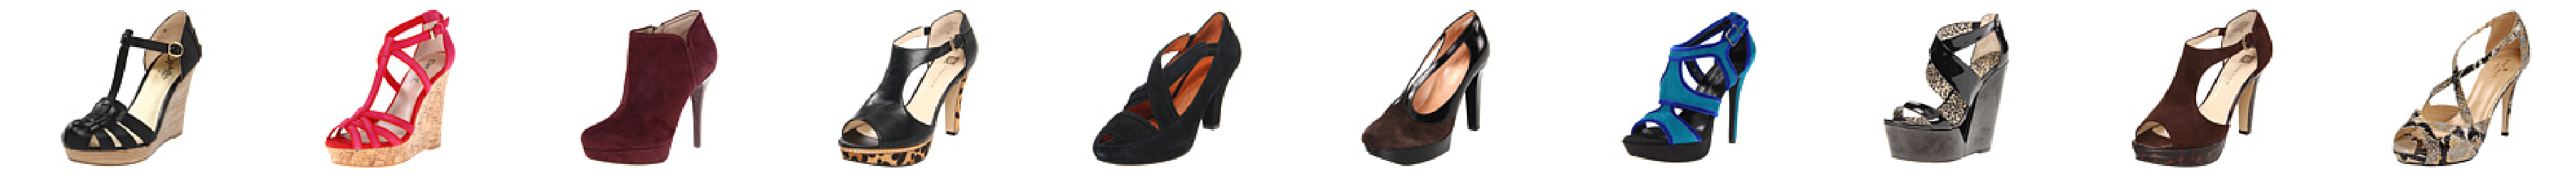

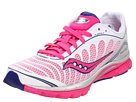

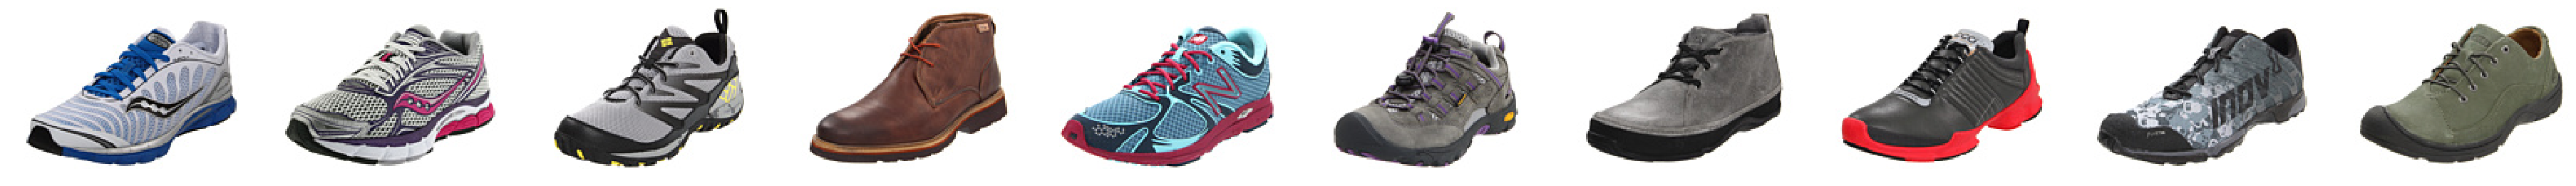

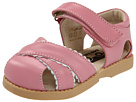

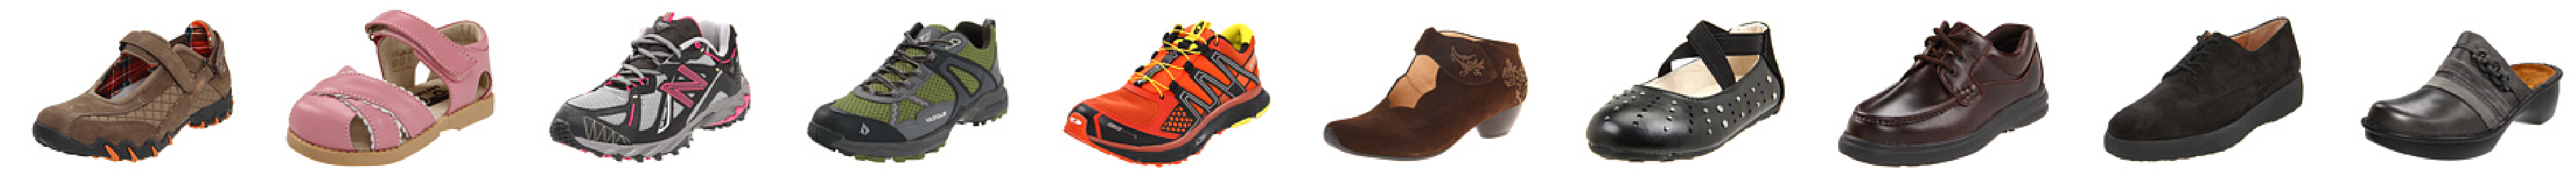

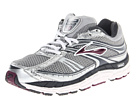

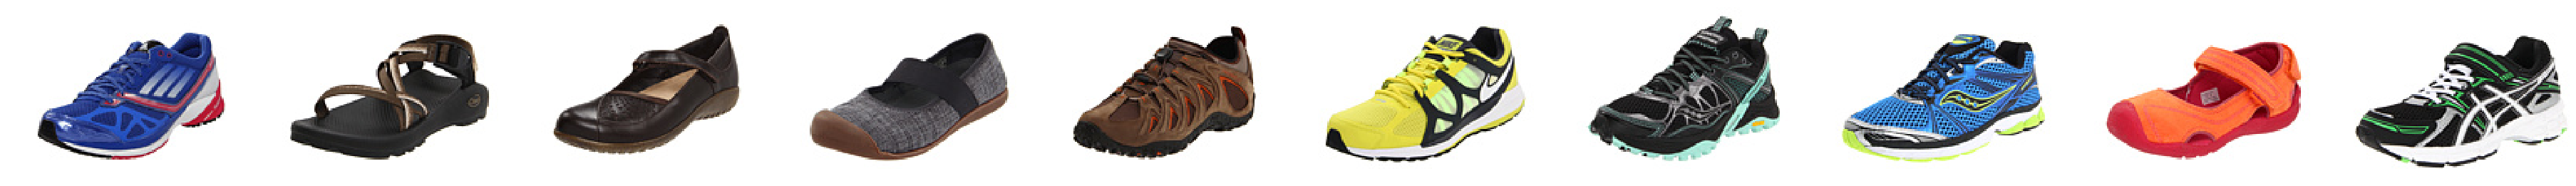

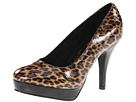

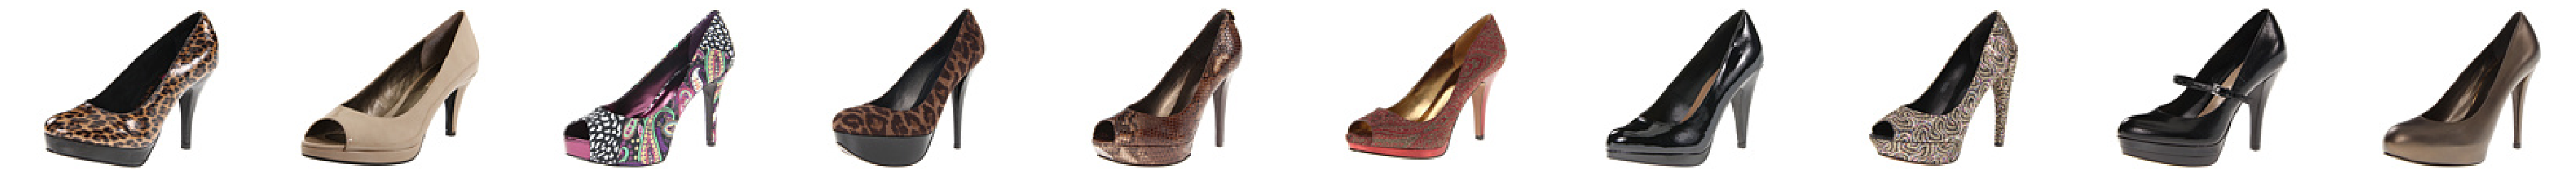

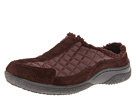

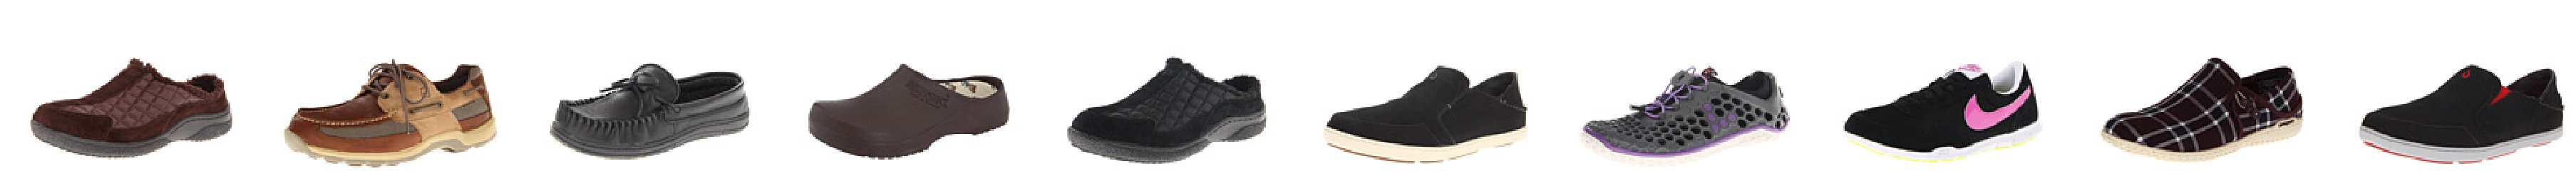

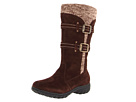

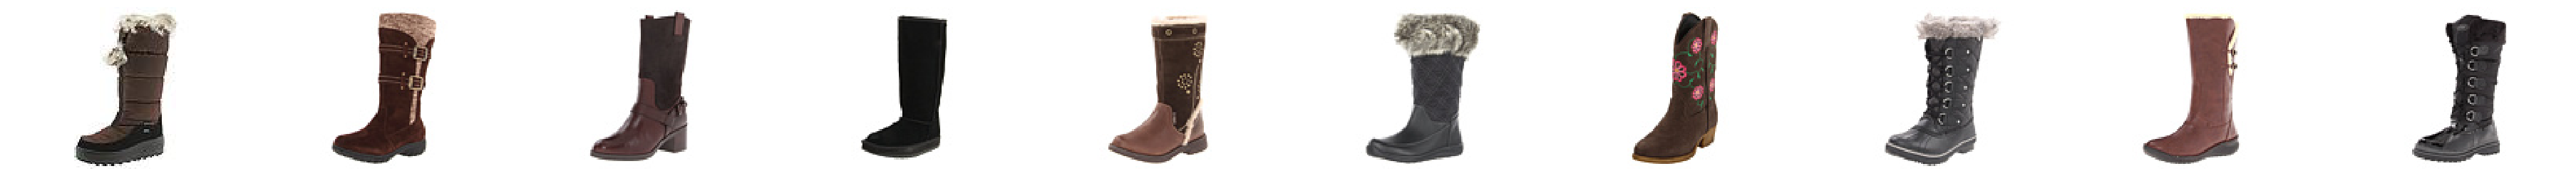

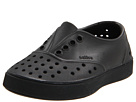

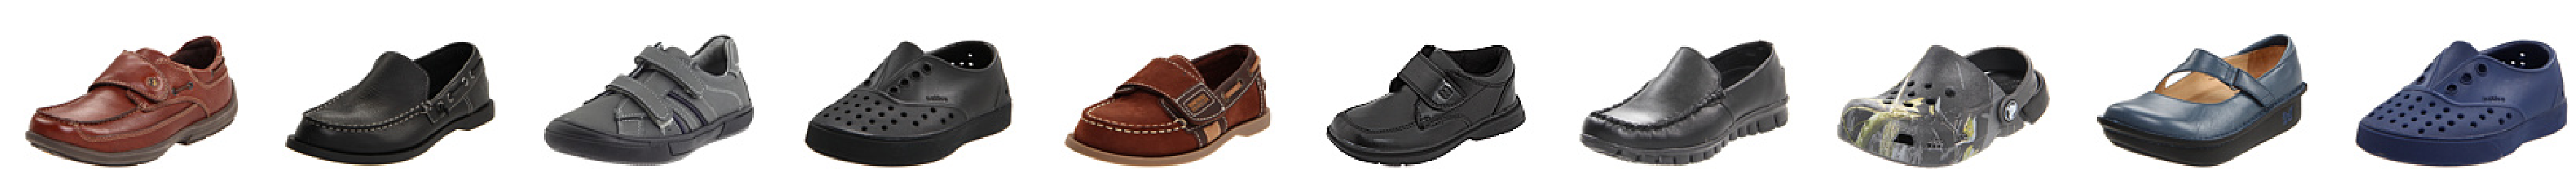

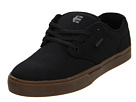

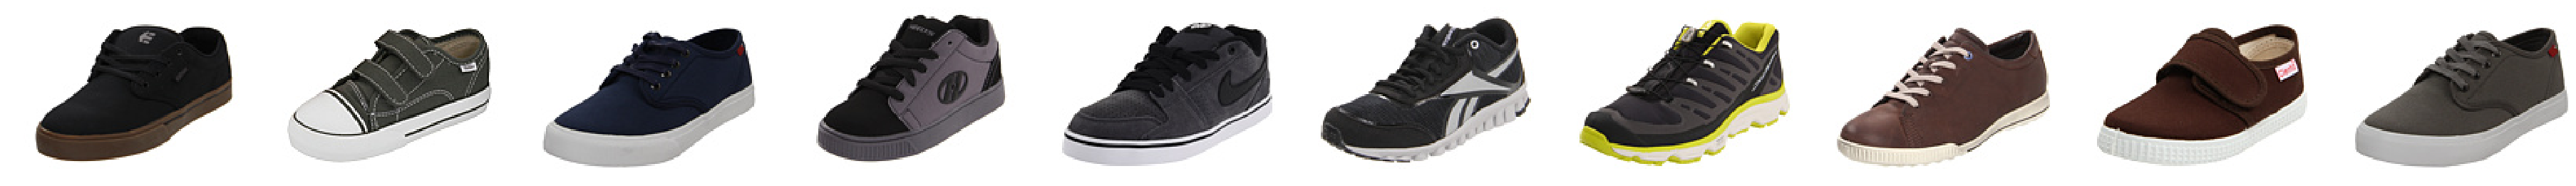

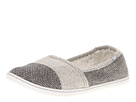

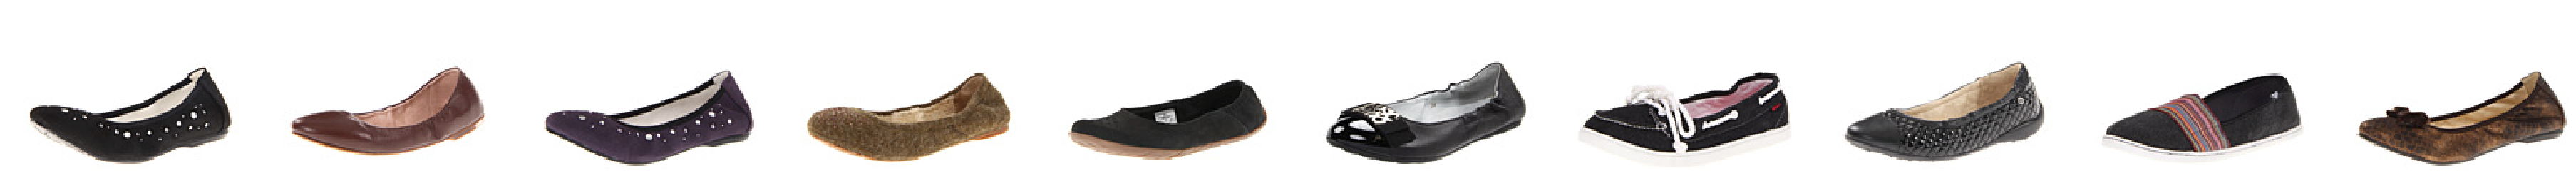

In [6]:
for i in range(0,len(result_in)):
    display(Image(result_in[i]))
    fig = figure(figsize=(64, 96))
    count = len(result_out[i])
    for j in range(0,count):
        z = '/notebooks'+result_out[i][j]['path']
        a=fig.add_subplot(1,count,j+1)
        image = imread(z)
        imshow(image,cmap='Greys_r')
        axis('off')
    display(fig)